PRCL-0015: Credit Risk Prediction

Client: Bank GoodCredit

Goal: Predict customer creditworthiness (Bad_label)

1. Import Libraries

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


2. Data Extraction 

Connect to MySQL

In [2]:
conn = mysql.connector.connect(
    host="18.136.157.135",
    port=3306,
    user="dm_team1",
    password="DM!$Team&279@20!",
    database="project_banking"
)

Load tables

In [3]:
cust_account = pd.read_sql("SELECT * FROM Cust_Account", conn)
cust_enquiry = pd.read_sql("SELECT * FROM Cust_Enquiry", conn)
cust_demo = pd.read_sql("SELECT * FROM Cust_Demographics", conn)

print("Account:", cust_account.shape)
print("Enquiry:", cust_enquiry.shape)
print("Demo:", cust_demo.shape)

Account: (186329, 21)
Enquiry: (413188, 6)
Demo: (23896, 83)


3. Exploratory Data Analysis (EDA)

In [4]:
cust_account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186329 entries, 0 to 186328
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dt_opened            186329 non-null  object
 1   customer_no          186329 non-null  object
 2   upload_dt            186329 non-null  object
 3   acct_type            186329 non-null  object
 4   owner_indic          186329 non-null  object
 5   opened_dt            186329 non-null  object
 6   last_paymt_dt        186329 non-null  object
 7   closed_dt            186329 non-null  object
 8   reporting_dt         186329 non-null  object
 9   high_credit_amt      186329 non-null  object
 10  cur_balance_amt      186329 non-null  object
 11  amt_past_due         186329 non-null  object
 12  paymenthistory1      186329 non-null  object
 13  paymenthistory2      186329 non-null  object
 14  paymt_str_dt         186329 non-null  object
 15  paymt_end_dt         186329 non-nu

In [5]:
cust_account.describe()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,...,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
count,186329,186329,186329,186329,186329,186329,186329,186329,186329,186329,...,186329,186329,186329,186329,186329,186329,186329,186329,186329,186329
unique,197,23896,75,31,4,6246,4511,4840,1877,67555,...,630,18311,11912,234,235,1380,1456,1476,3,18300
top,16-Nov-15,8516,21-Apr-15,10,1,13-Apr-12,,,31-Jul-15,,...,,"""""""0000000000000000000000000000000000000000000...",,01-Jul-15,01-Jan-15,,,,,
freq,4643,120,5128,100239,177287,514,25487,109075,12654,8875,...,185453,44979,107824,16747,5640,137477,151047,161496,122436,145276


In [6]:
cust_enquiry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413188 entries, 0 to 413187
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   dt_opened    413188 non-null  object
 1   customer_no  413188 non-null  object
 2   upload_dt    413188 non-null  object
 3   enquiry_dt   413188 non-null  object
 4   enq_purpose  413188 non-null  object
 5   enq_amt      413188 non-null  object
dtypes: object(6)
memory usage: 18.9+ MB


In [7]:
cust_enquiry.describe()

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
count,413188,413188,413188,413188,413188,413188
unique,197,23896,76,3772,37,7384
top,16-Nov-15,10076,21-Apr-15,17-Mar-15,10,50000
freq,10538,308,11770,495,238150,79949


In [8]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23896 entries, 0 to 23895
Data columns (total 83 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   dt_opened    23896 non-null  object
 1   customer_no  23896 non-null  object
 2   entry_time   23896 non-null  object
 3   feature_1    23896 non-null  object
 4   feature_2    23896 non-null  object
 5   feature_3    23896 non-null  object
 6   feature_4    23896 non-null  object
 7   feature_5    23896 non-null  object
 8   feature_6    23896 non-null  object
 9   feature_7    23896 non-null  object
 10  feature_8    23896 non-null  object
 11  feature_9    23896 non-null  object
 12  feature_10   23896 non-null  object
 13  feature_11   23896 non-null  object
 14  feature_12   23896 non-null  object
 15  feature_13   23896 non-null  object
 16  feature_14   23896 non-null  object
 17  feature_15   23896 non-null  object
 18  feature_16   23896 non-null  object
 19  feature_17   23896 non-nu

In [9]:
cust_demo.describe()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
count,23896,23896,23896,23896,23896,23896,23896,23896,23896,23896,...,23896,23896,23896,23896,23896,23896,23896,23896,23896,23896
unique,197,23896,297,8,282,263,4,2,2,485,...,14,3,3,4,63,6,3124,4,3,2
top,16-Nov-15,1,19-Oct-15,Platinum Maxima,,,3,Card Setup,14,35000,...,10,R,,,0000-00-00,0,XXXXX,1,N,0
freq,699,1,180,9056,2836,2836,14593,23881,23881,797,...,9760,15617,20951,23879,23820,23817,2149,22958,23876,22892


In [10]:
def missing_summary(df, name):
    ms = df.isnull().mean().sort_values(ascending=False) * 100
    ms = ms.round(2)
    print(f"\n{name} - Missing Values (%)")
    print(ms)

# Run on all tables
missing_summary(cust_account, "Cust_Account")
missing_summary(cust_enquiry, "Cust_Enquiry")
missing_summary(cust_demo, "Cust_Demographics")


Cust_Account - Missing Values (%)
dt_opened              0.0
amt_past_due           0.0
paymentfrequency       0.0
rateofinterest         0.0
cashlimit              0.0
creditlimit            0.0
paymt_end_dt           0.0
paymt_str_dt           0.0
paymenthistory2        0.0
paymenthistory1        0.0
cur_balance_amt        0.0
customer_no            0.0
high_credit_amt        0.0
reporting_dt           0.0
closed_dt              0.0
last_paymt_dt          0.0
opened_dt              0.0
owner_indic            0.0
acct_type              0.0
upload_dt              0.0
actualpaymentamount    0.0
dtype: float64

Cust_Enquiry - Missing Values (%)
dt_opened      0.0
customer_no    0.0
upload_dt      0.0
enquiry_dt     0.0
enq_purpose    0.0
enq_amt        0.0
dtype: float64

Cust_Demographics - Missing Values (%)
dt_opened     0.0
feature_60    0.0
feature_58    0.0
feature_57    0.0
feature_56    0.0
             ... 
feature_24    0.0
feature_23    0.0
feature_22    0.0
feature_21    0.0

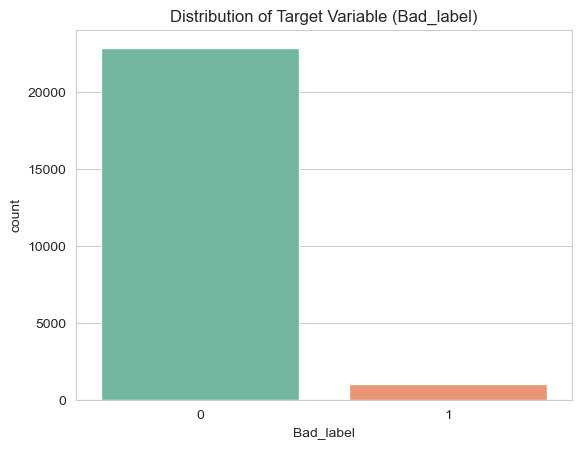

In [11]:
# Target distribution
sns.countplot(x="Bad_label", data=cust_demo, palette="Set2")
plt.title("Distribution of Target Variable (Bad_label)")
plt.show()

In [12]:
print(cust_demo["Bad_label"].value_counts(normalize=True))

Bad_label
0    0.957985
1    0.042015
Name: proportion, dtype: float64


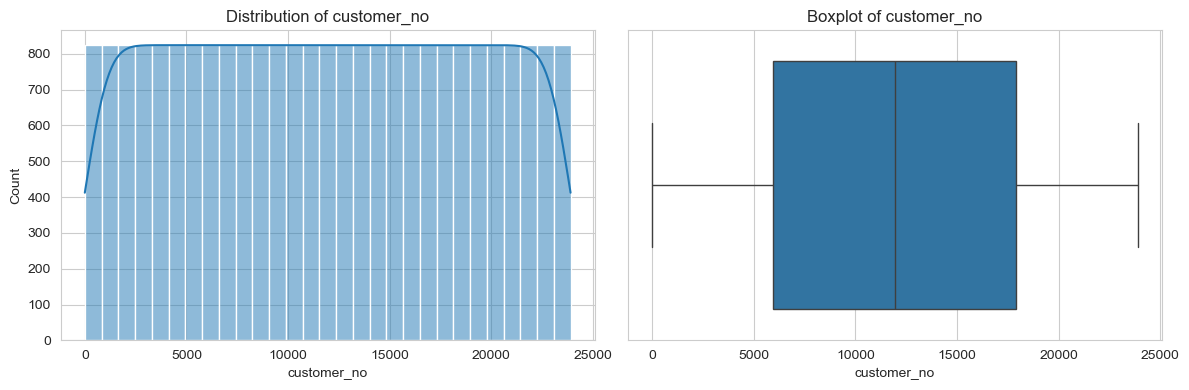

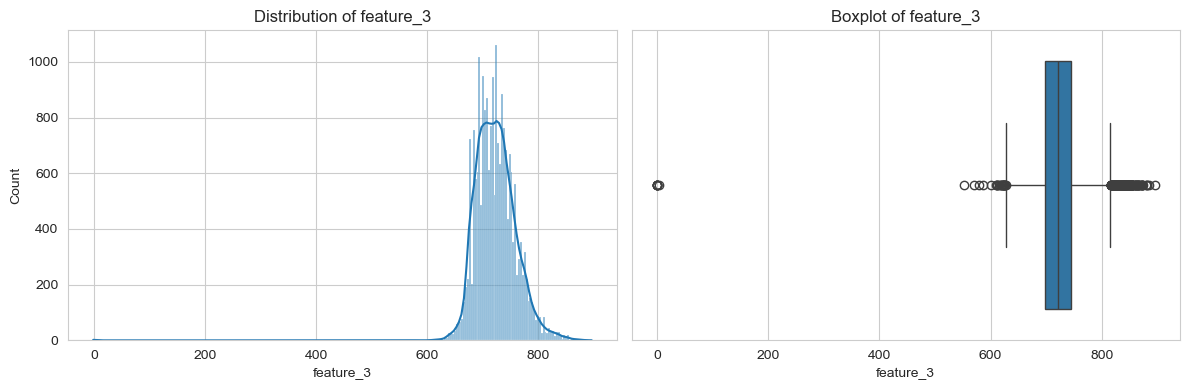

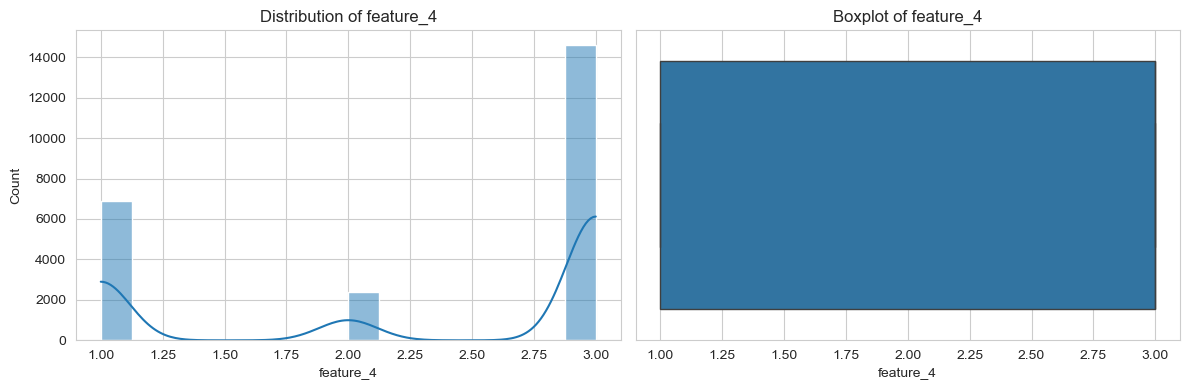

 Skipping feature_6 (constant or empty)


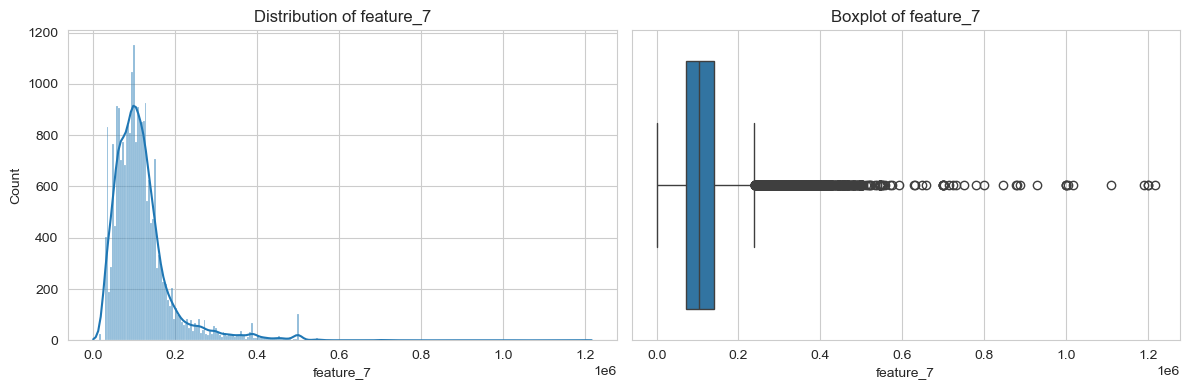

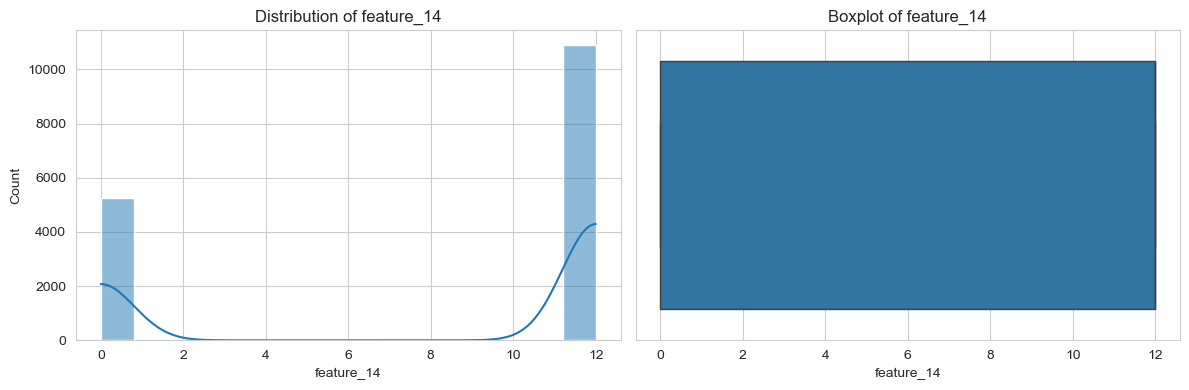

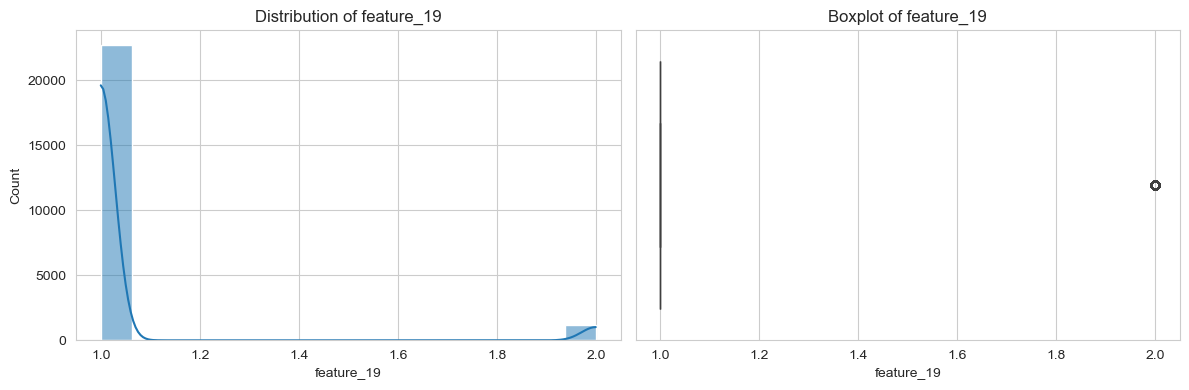

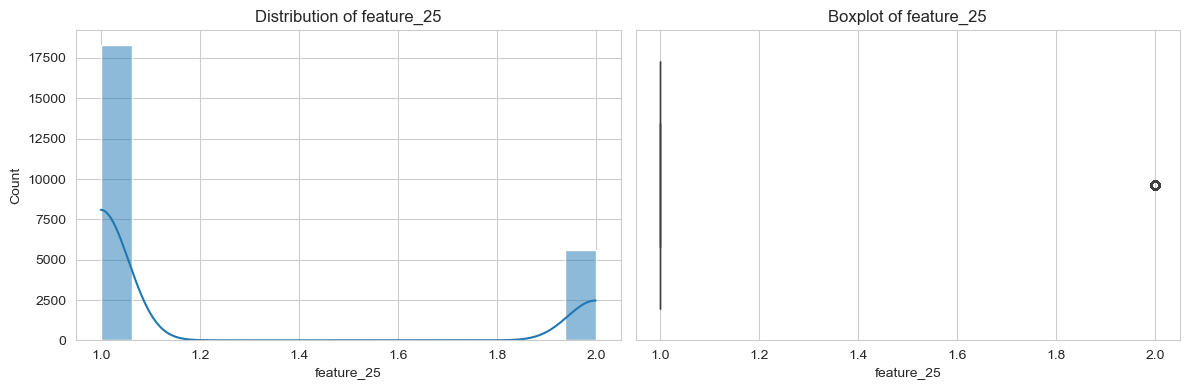

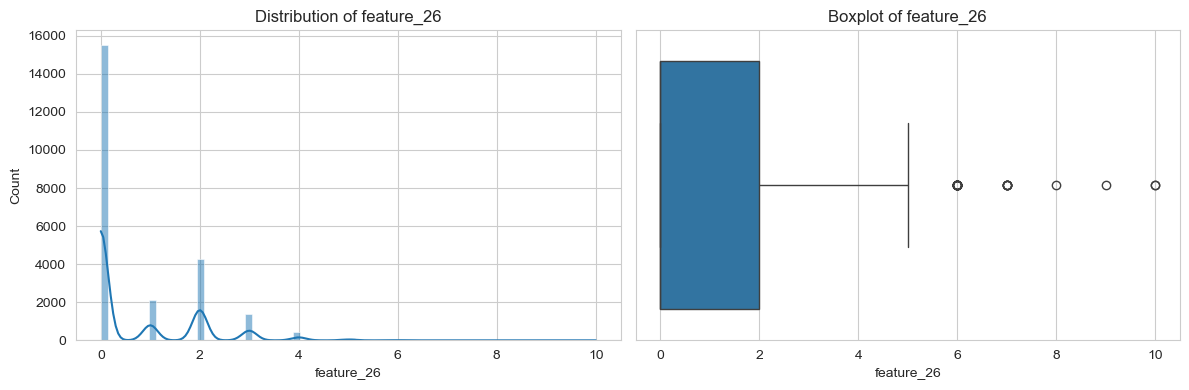

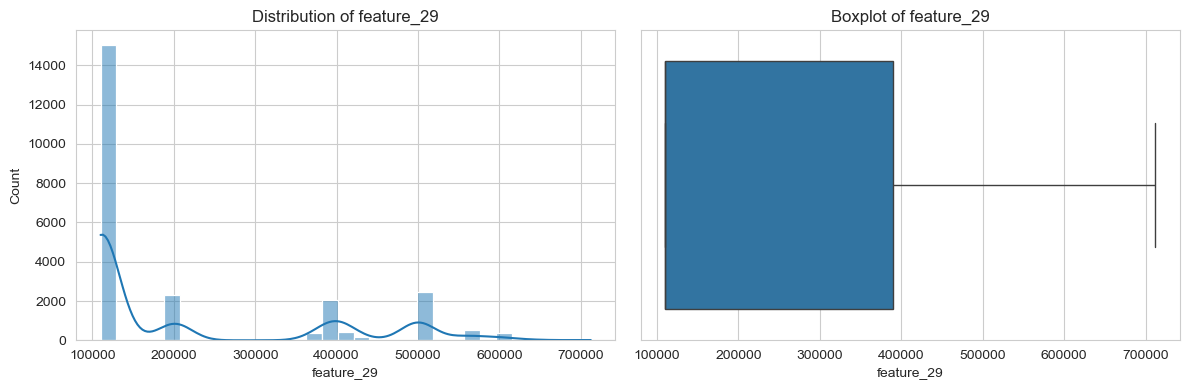

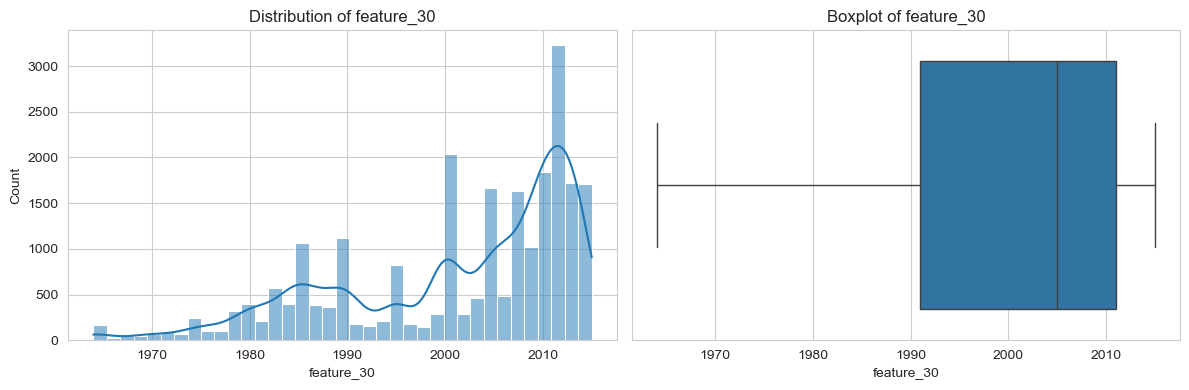

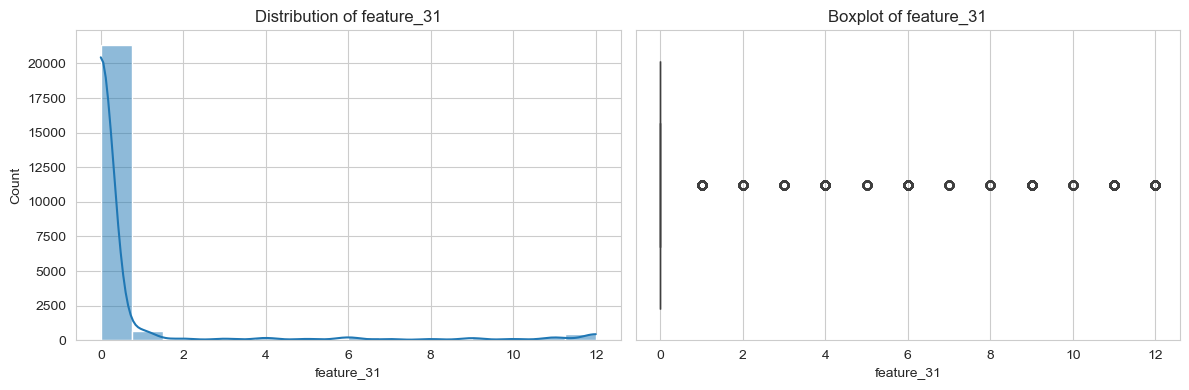

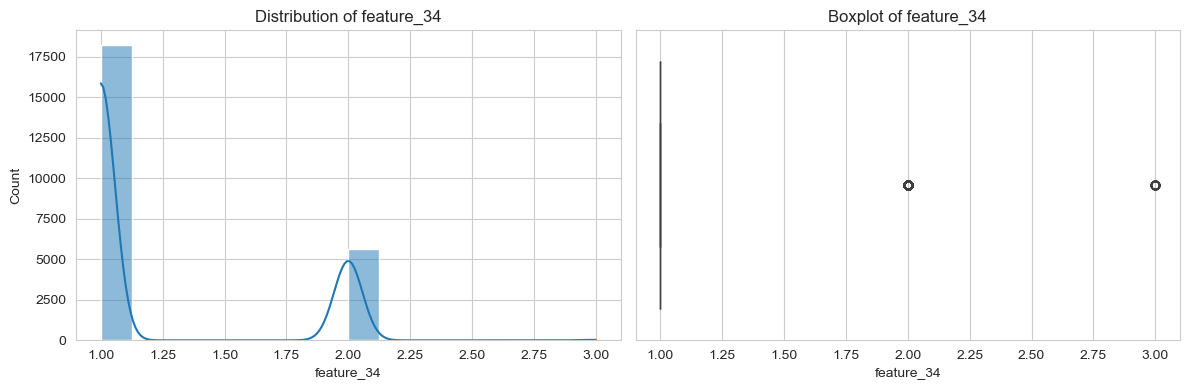

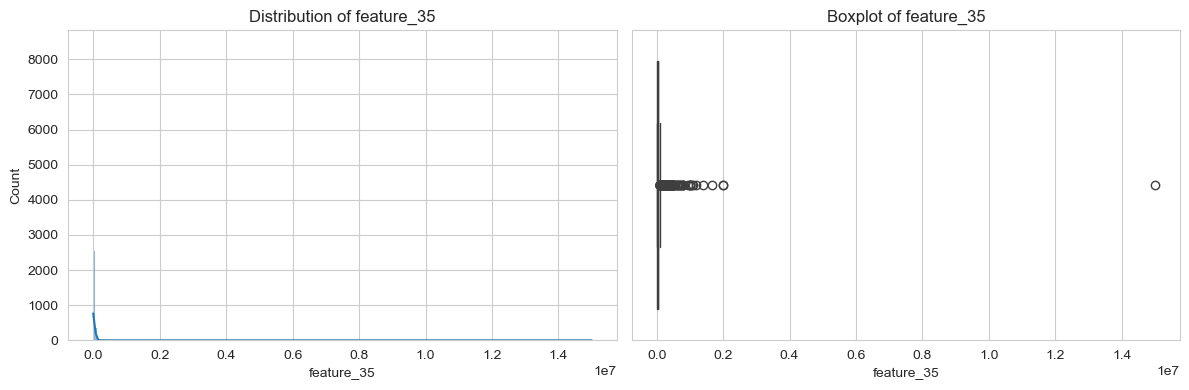

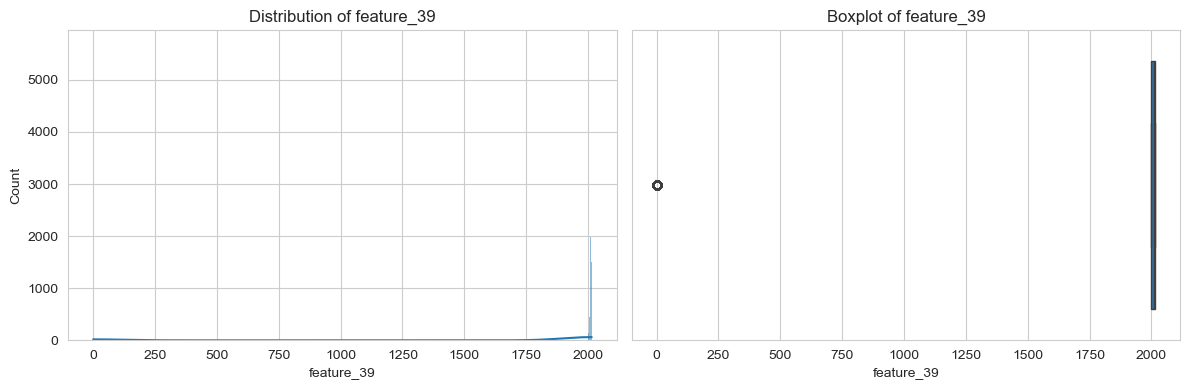

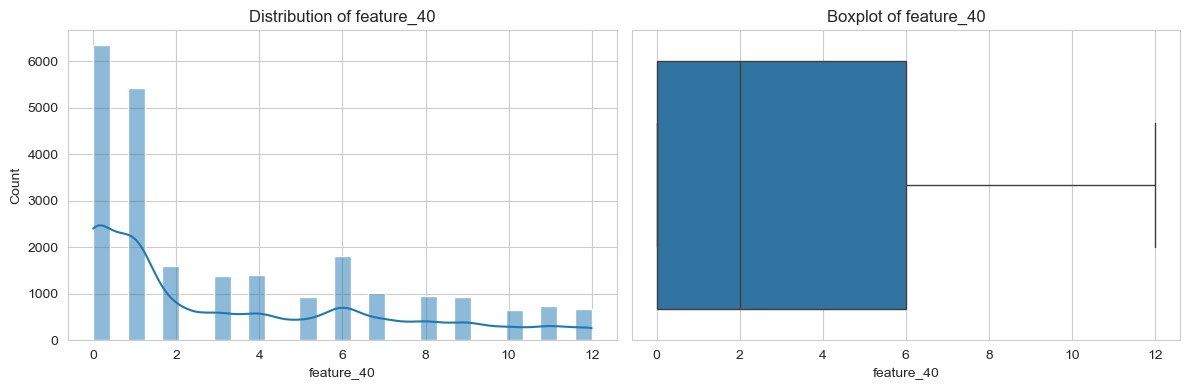

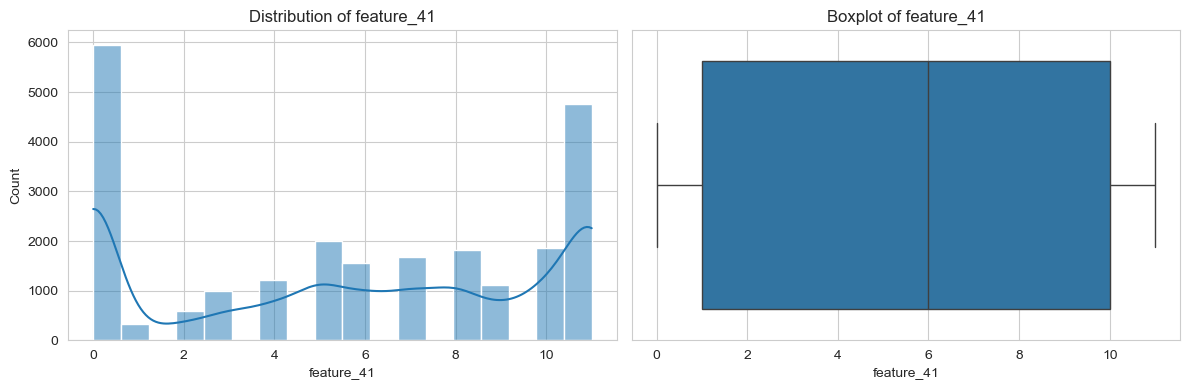

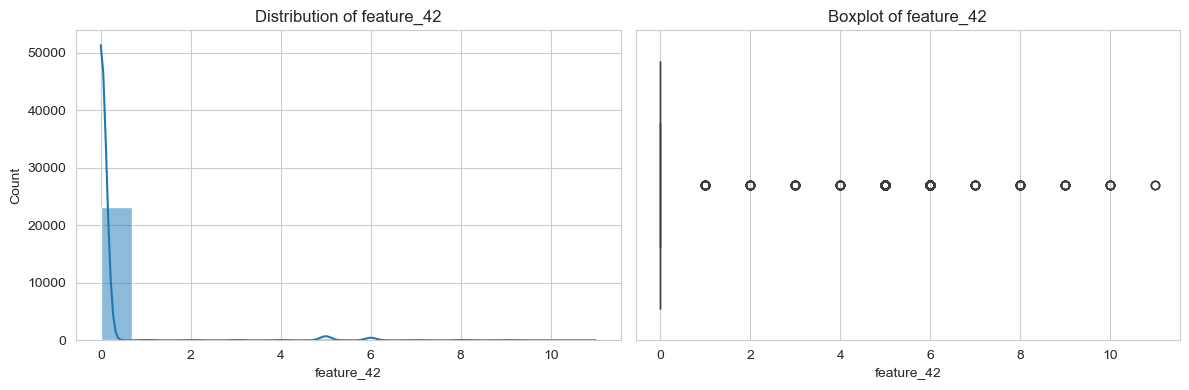

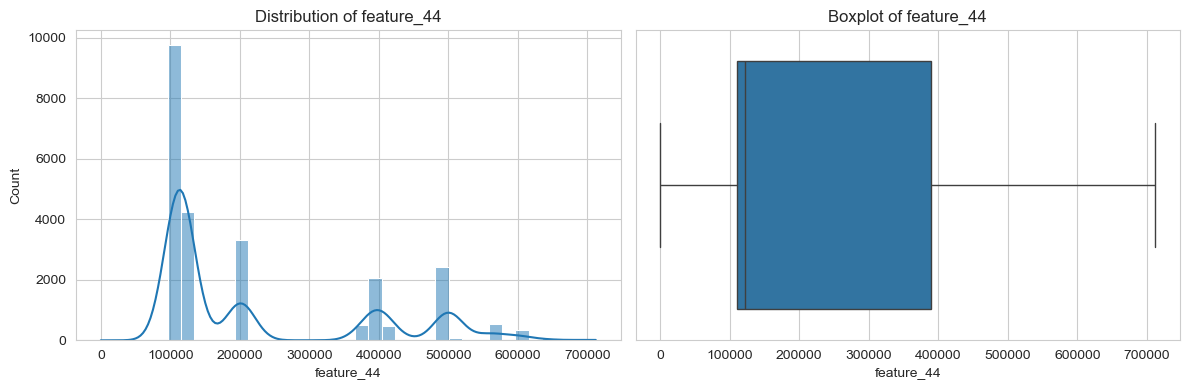

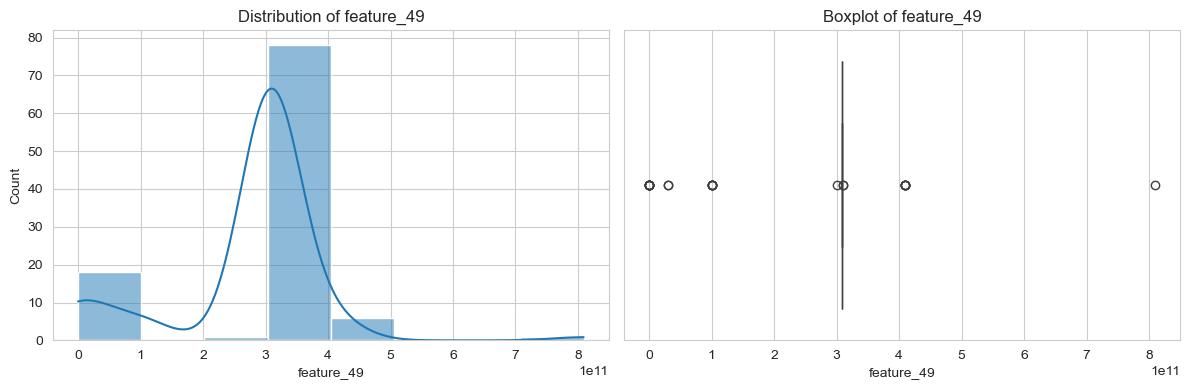

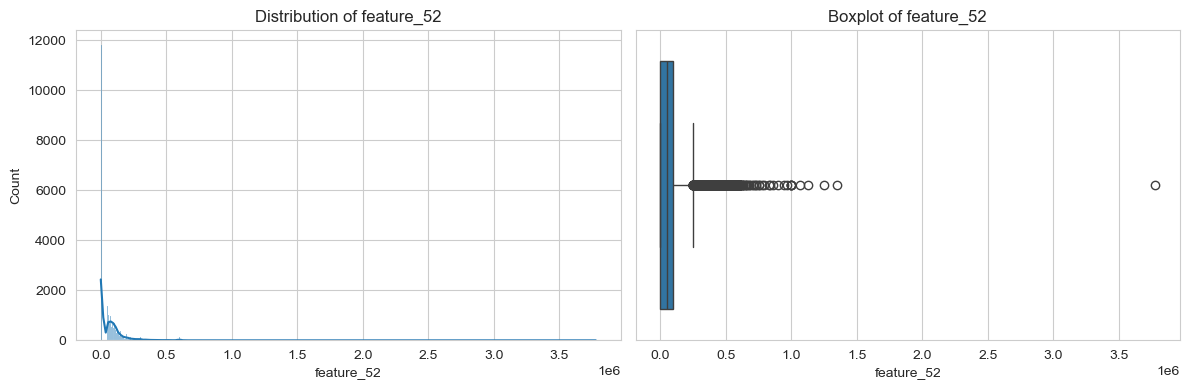

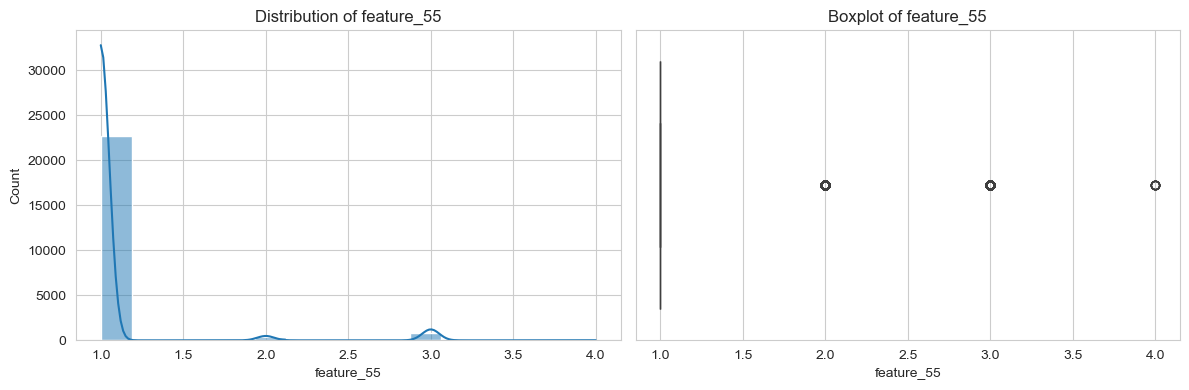

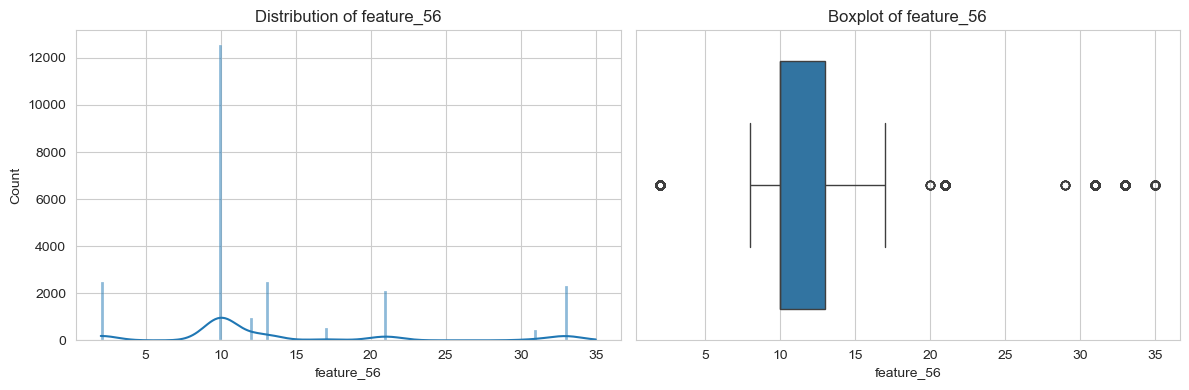

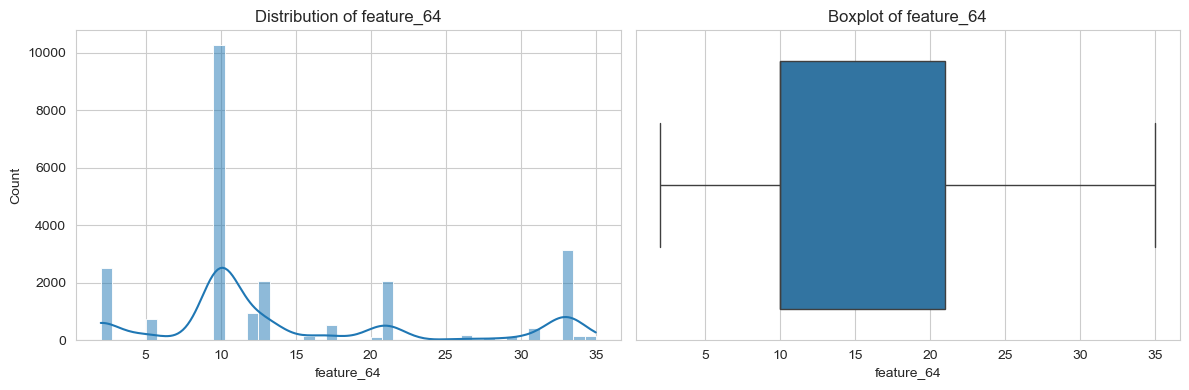

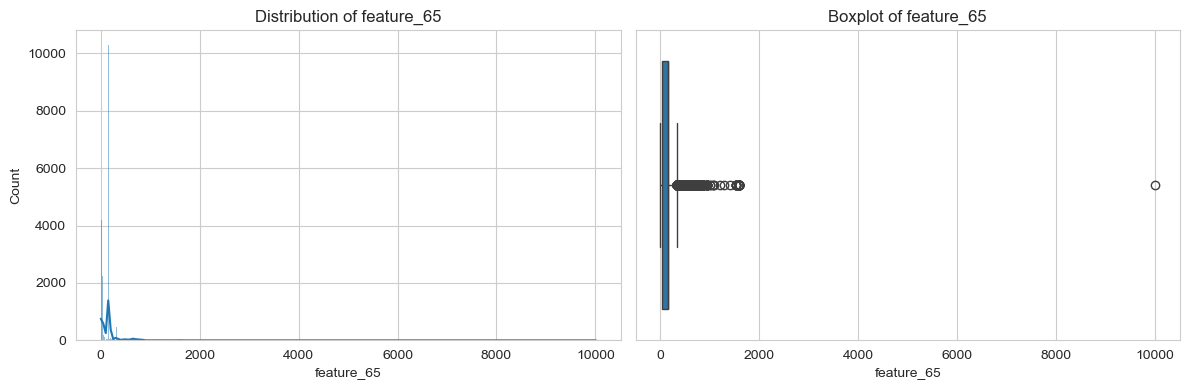

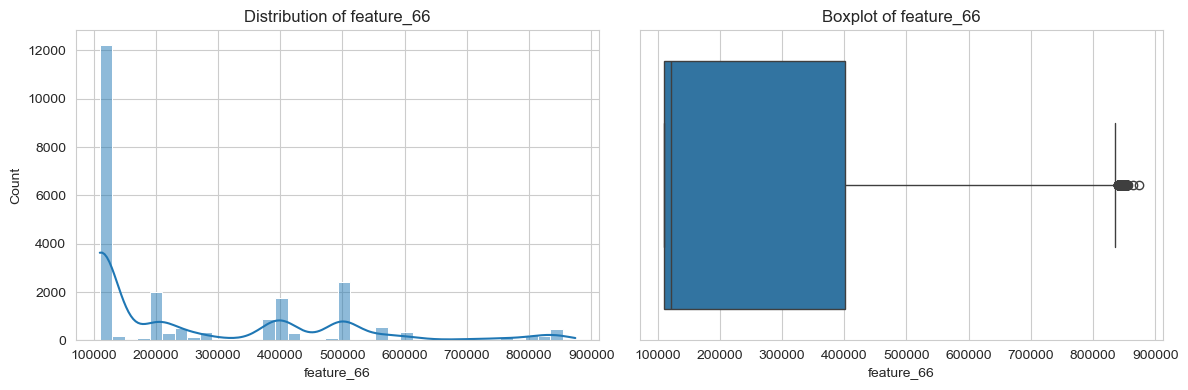

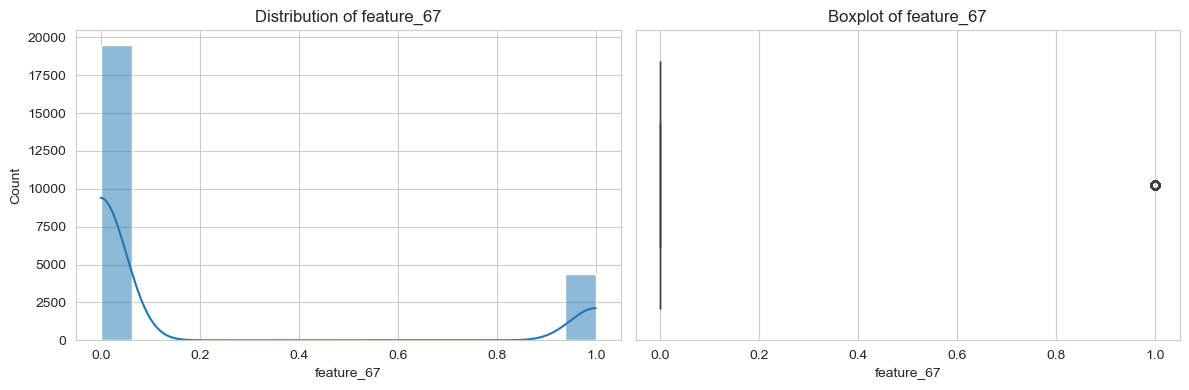

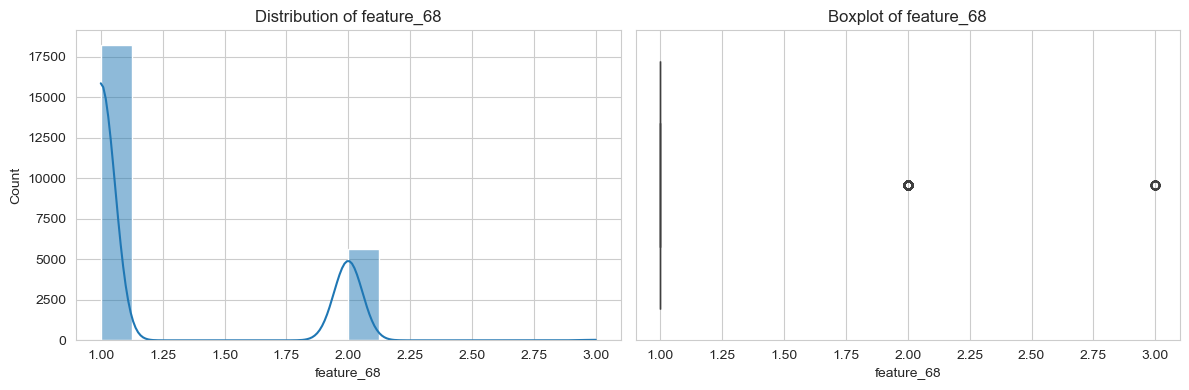

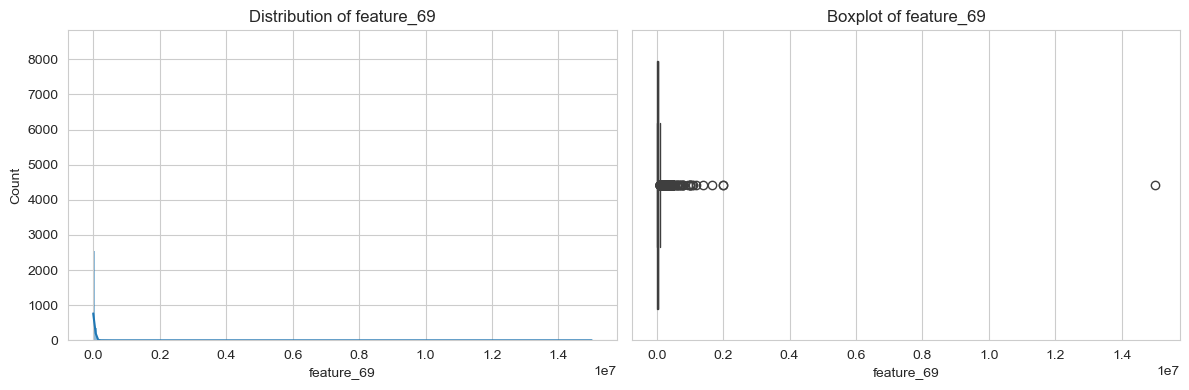

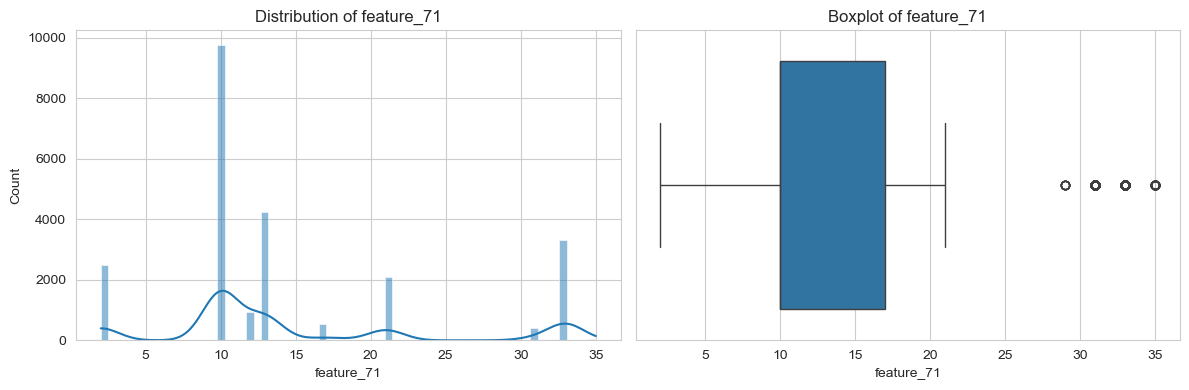

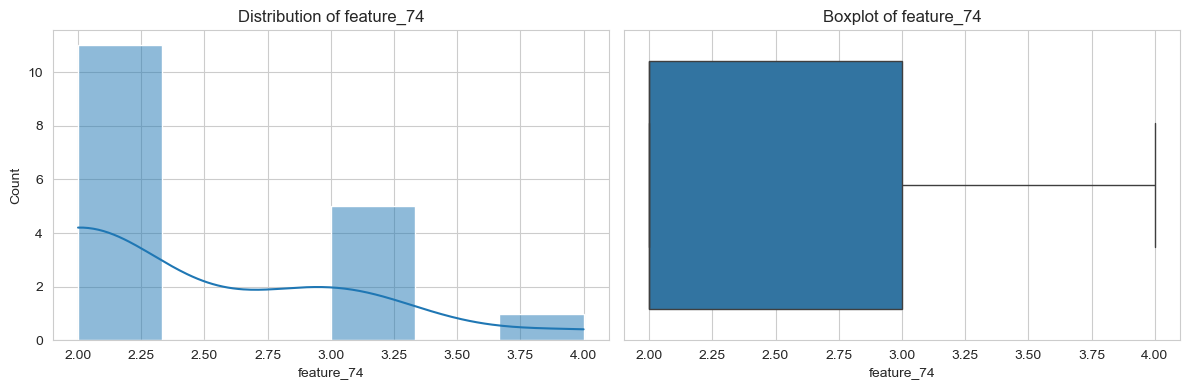

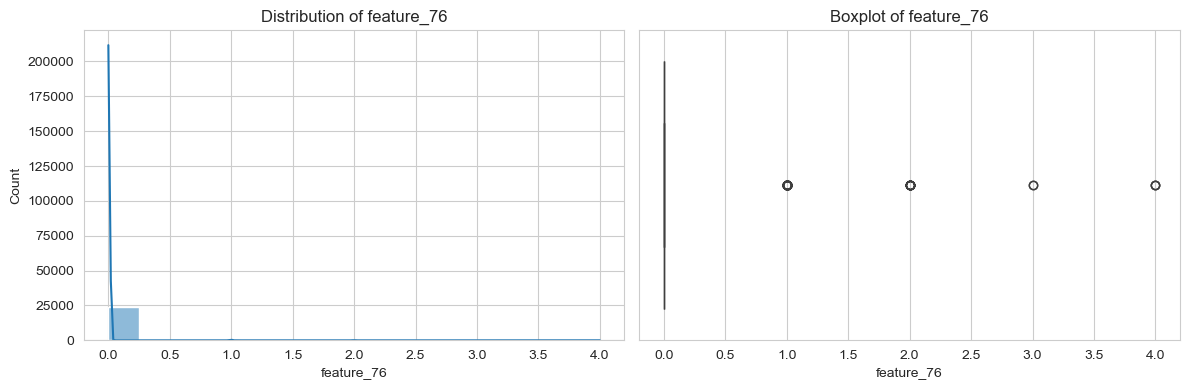

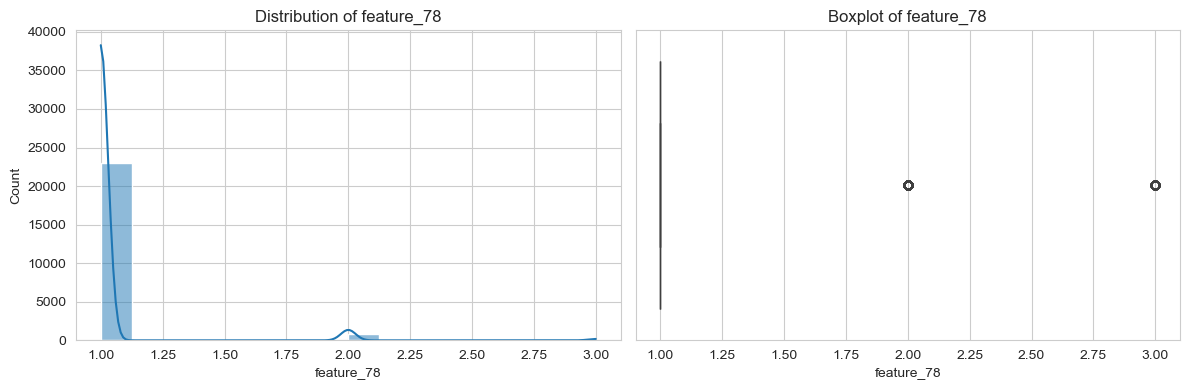

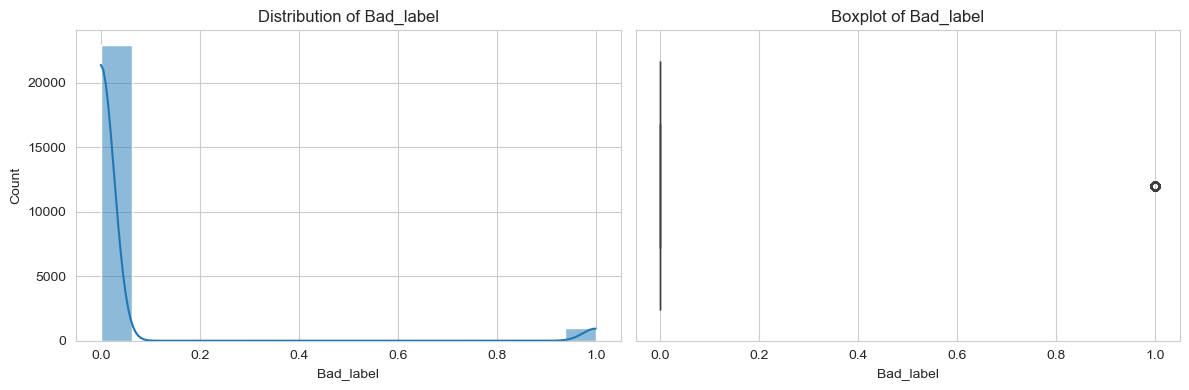

In [13]:
cust_demo_num = cust_demo.apply(pd.to_numeric, errors="ignore")

# Select numeric columns
num_cols = cust_demo_num.select_dtypes(include=[np.number]).columns

if len(num_cols) == 0:
    print("⚠️ No numeric columns found for distribution plots.")
else:
    for col in num_cols:
        if cust_demo_num[col].nunique() > 1:   # only plot if >1 unique value
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram + KDE
            sns.histplot(cust_demo_num[col].dropna(), kde=True, ax=axes[0])
            axes[0].set_title(f"Distribution of {col}")

            # Boxplot
            sns.boxplot(x=cust_demo_num[col].dropna(), ax=axes[1])
            axes[1].set_title(f"Boxplot of {col}")

            plt.tight_layout()
            plt.show()
        else:
            print(f" Skipping {col} (constant or empty)")


4. Data Cleaning

In [14]:
def clean_numeric(df, table_name=""):
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = pd.to_numeric(df[col], errors="ignore")
    df = df.fillna(0)
    print(f" {table_name} cleaned | Shape: {df.shape}")
    return df

cust_account = clean_numeric(cust_account, "Cust_Account")
cust_enquiry = clean_numeric(cust_enquiry, "Cust_Enquiry")
cust_demo = clean_numeric(cust_demo, "Cust_Demographics")

 Cust_Account cleaned | Shape: (186329, 21)
 Cust_Enquiry cleaned | Shape: (413188, 6)
 Cust_Demographics cleaned | Shape: (23896, 83)


5. Feature Engineering

In [15]:
# Account features
cust_account["ratio_balance_limit"] = cust_account["cur_balance_amt"] / (cust_account["creditlimit"] + 1)
account_features = cust_account.groupby("customer_no").agg({
    "cur_balance_amt": "mean",
    "creditlimit": "mean",
    "ratio_balance_limit": "mean"
}).reset_index()


In [16]:
# Enquiry features
cust_enquiry["enquiry_dt"] = pd.to_datetime(cust_enquiry["enquiry_dt"], errors="coerce")
cust_enquiry["dt_opened"] = pd.to_datetime(cust_enquiry["dt_opened"], errors="coerce")
cust_enquiry["recency_days"] = (cust_enquiry["dt_opened"] - cust_enquiry["enquiry_dt"]).dt.days
enquiry_features = cust_enquiry.groupby("customer_no").agg({
    "enq_amt": "mean",
    "recency_days": "min"
}).reset_index()

In [17]:
# Merge features into demographics
cust_demo = cust_demo.merge(account_features, on="customer_no", how="left")
cust_demo = cust_demo.merge(enquiry_features, on="customer_no", how="left")
print("Final dataset shape:", cust_demo.shape)

Final dataset shape: (23896, 88)


6. Preprocessing

In [18]:
# Separate features and target
X = cust_demo.drop(columns=["Bad_label","customer_no","dt_opened","entry_time"], errors="ignore")
y = cust_demo["Bad_label"]

In [19]:
# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
print("Numeric Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numeric Columns: ['feature_3', 'feature_4', 'feature_6', 'feature_7', 'feature_14', 'feature_19', 'feature_25', 'feature_26', 'feature_29', 'feature_30', 'feature_31', 'feature_34', 'feature_35', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_44', 'feature_49', 'feature_52', 'feature_55', 'feature_56', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 'feature_71', 'feature_74', 'feature_76', 'feature_78', 'cur_balance_amt', 'creditlimit', 'ratio_balance_limit', 'enq_amt', 'recency_days']
Categorical Columns: ['feature_1', 'feature_2', 'feature_5', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_27', 'feature_28', 'feature_32', 'feature_33', 'feature_36', 'feature_37', 'feature_38', 'feature_43', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_50', 'fe

In [20]:
# numeric pipeline:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [21]:
# categorical pipeline:
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

In [22]:
# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [23]:
def evaluate_pipeline(pipe, X_train, X_test, y_train, y_test, name):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # ensure predict_proba exists
    if hasattr(pipe, "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:,1]
    else:
        # fallback: decision_function -> scale to [0,1]
        y_scores = pipe.decision_function(X_test)
        y_prob = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
    
    auc = roc_auc_score(y_test, y_prob)
    gini = 2*auc - 1
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {auc:.4f} | Gini: {gini:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(); plt.title(f"ROC Curve - {name}")
    plt.show()
    
    return auc, gini, pipe

7. MODELS 

1. Logistic Regression


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6868
           1       0.00      0.00      0.00       301

    accuracy                           0.96      7169
   macro avg       0.48      0.50      0.49      7169
weighted avg       0.92      0.96      0.94      7169

AUC: 0.5867 | Gini: 0.1734


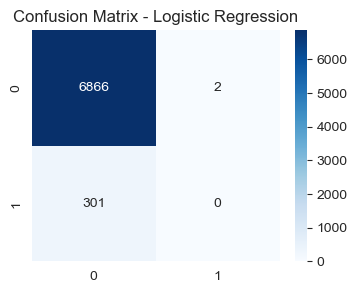

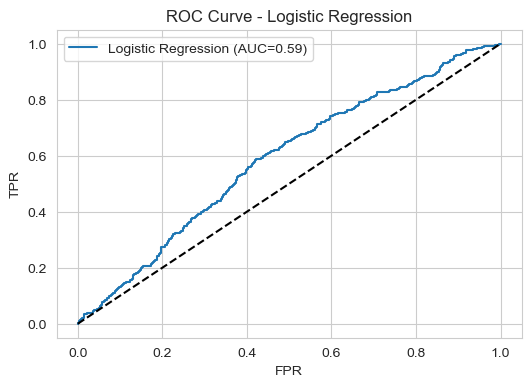

In [24]:
log_reg_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
])
auc_log, gini_log, log_reg_pipe = evaluate_pipeline(log_reg_pipe, X_train, X_test, y_train, y_test, "Logistic Regression")

2. RandomForest


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6868
           1       0.00      0.00      0.00       301

    accuracy                           0.96      7169
   macro avg       0.48      0.50      0.49      7169
weighted avg       0.92      0.96      0.94      7169

AUC: 0.5466 | Gini: 0.0932


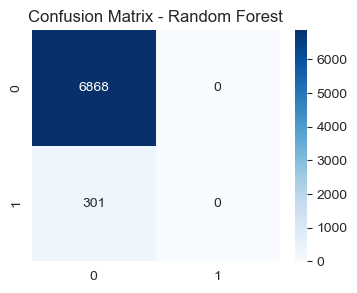

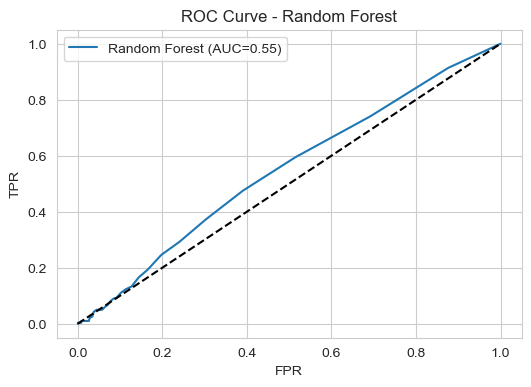

In [25]:
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])
auc_rf, gini_rf, rf_pipe = evaluate_pipeline(rf_pipe, X_train, X_test, y_train, y_test, "Random Forest")

3. Gradient Boosting


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6868
           1       0.17      0.01      0.01       301

    accuracy                           0.96      7169
   macro avg       0.56      0.50      0.50      7169
weighted avg       0.92      0.96      0.94      7169

AUC: 0.6345 | Gini: 0.2689


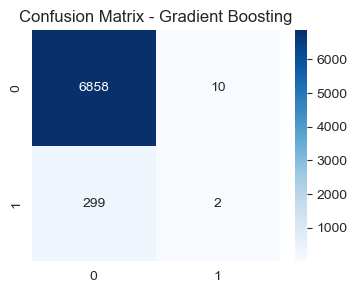

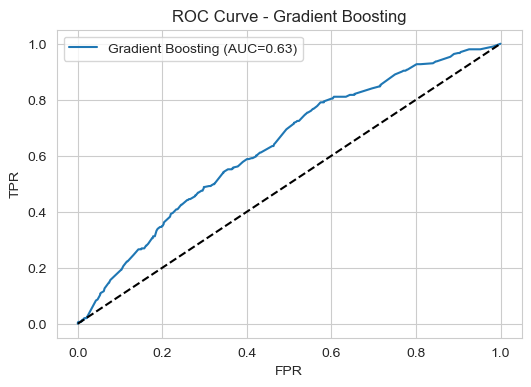

In [26]:
gb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", GradientBoostingClassifier(n_estimators=200, random_state=42))
])
auc_gb, gini_gb, gb_pipe = evaluate_pipeline(gb_pipe, X_train, X_test, y_train, y_test, "Gradient Boosting")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

=== Tuned Random Forest ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6868
           1       0.00      0.00      0.00       301

    accuracy                           0.96      7169
   macro avg       0.48      0.50      0.49      7169
weighted avg       0.92      0.96      0.94      7169

AUC: 0.6226 | Gini: 0.2452


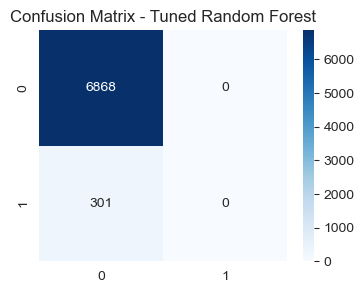

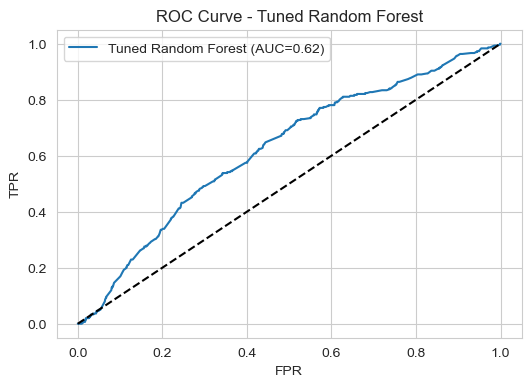

In [27]:
# Random Forest tuning

rf_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10],
    "clf__min_samples_split": [2, 5]
}
rf_search = GridSearchCV(rf_pipe, rf_grid, scoring="roc_auc", cv=3, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)
best_rf_pipe = rf_search.best_estimator_
auc_rf_tuned, gini_rf_tuned, best_rf_pipe = evaluate_pipeline(best_rf_pipe, X_train, X_test, y_train, y_test, "Tuned Random Forest")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

=== Tuned Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6868
           1       0.10      0.00      0.01       301

    accuracy                           0.96      7169
   macro avg       0.53      0.50      0.49      7169
weighted avg       0.92      0.96      0.94      7169

AUC: 0.6353 | Gini: 0.2707


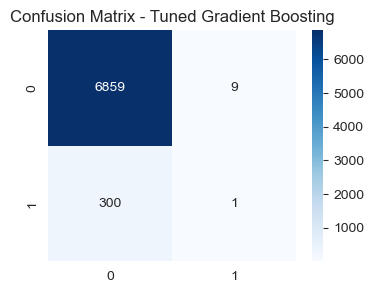

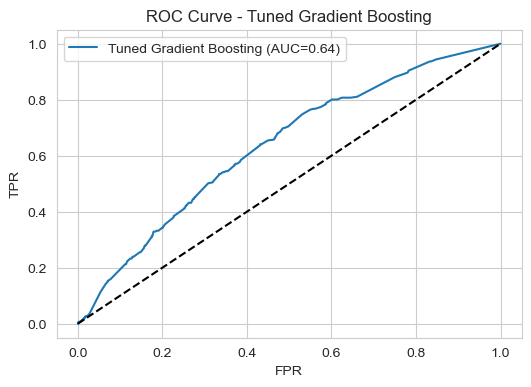

In [28]:
# Gradient Boosting tuning
gb_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 5]
}
gb_search = GridSearchCV(gb_pipe, gb_grid, scoring="roc_auc", cv=3, n_jobs=-1, verbose=1)
gb_search.fit(X_train, y_train)
best_gb_pipe = gb_search.best_estimator_
auc_gb_tuned, gini_gb_tuned, best_gb_pipe = evaluate_pipeline(best_gb_pipe, X_train, X_test, y_train, y_test, "Tuned Gradient Boosting")

8. Feature importance (RF & GB)

In [29]:

def get_feature_names_from_preprocessor(preprocessor, num_cols, cat_cols):
    names = []
    if num_cols:
        names.extend(num_cols)
    if cat_cols:
        # preprocessor must be fitted
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        ohe_names = list(ohe.get_feature_names_out(cat_cols))
        names.extend(ohe_names)
    return names

In [30]:
fitted_preproc = best_rf_pipe.named_steps["preprocessor"]
feature_names = get_feature_names_from_preprocessor(fitted_preproc, num_cols, cat_cols)


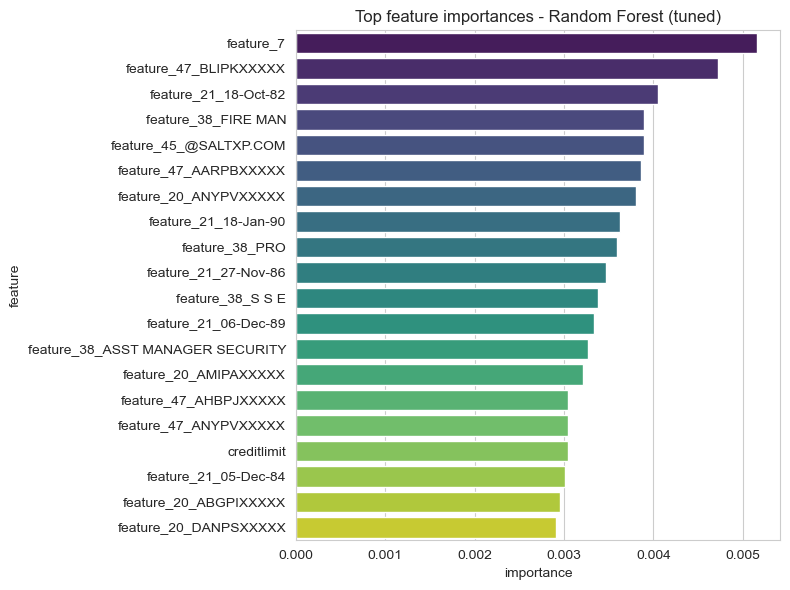

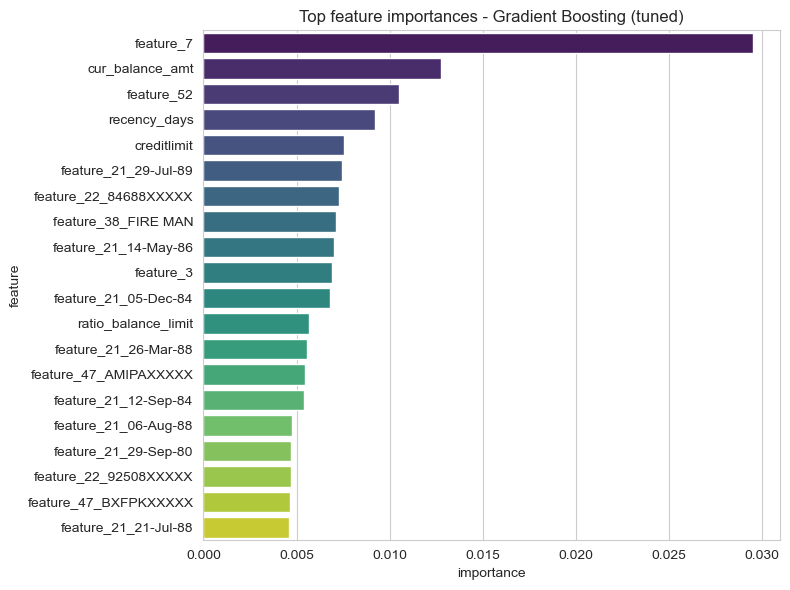

In [31]:
def plot_feature_importance(fitted_pipe, feature_names, title):
    clf = fitted_pipe.named_steps["clf"]
    if not hasattr(clf, "feature_importances_"):
        print(f"⚠️ {title} - classifier has no feature_importances_")
        return None
    imp = clf.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": imp})
    fi = fi.sort_values("importance", ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x="importance", y="feature", data=fi, palette="viridis")
    plt.title(f"Top feature importances - {title}")
    plt.tight_layout()
    plt.show()
    return fi

rf_fi = plot_feature_importance(best_rf_pipe, feature_names, "Random Forest (tuned)")
gb_fi = plot_feature_importance(best_gb_pipe, feature_names, "Gradient Boosting (tuned)")

9. Decile analysis (safe)

,decile,total,bads,goods,mean_score,bad_rate
9,10,582,48,534,0.124903,0.082474
8,9,829,52,777,0.048820,0.062726
7,8,658,38,620,0.040230,0.057751
6,7,756,38,718,0.035347,0.050265
5,6,713,34,679,0.031607,0.047686
4,5,730,27,703,0.028849,0.036986
3,4,514,7,507,0.026413,0.013619
2,3,863,28,835,0.024812,0.032445
1,2,455,12,443,0.023516,0.026374
0,1,1069,17,1052,0.022217,0.015903


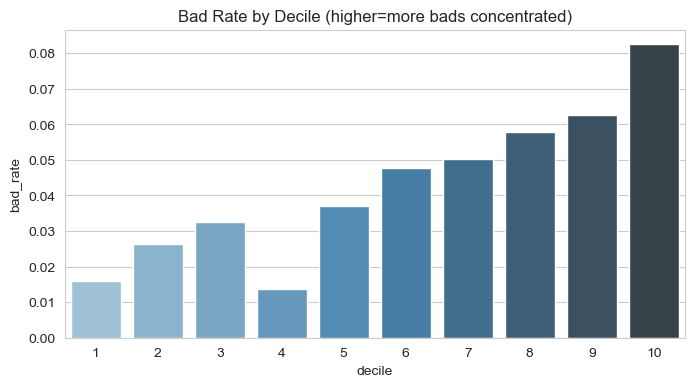

In [32]:

def decile_analysis(pipe, X_test, y_test):
    y_prob = pipe.predict_proba(X_test)[:,1]
    if len(np.unique(y_prob)) <= 1:
        print("⚠️ Constant probabilities — skipping decile analysis.")
        return pd.DataFrame()
    df = pd.DataFrame({"y_test": y_test.values, "y_prob": y_prob})
    df["decile"] = pd.qcut(df["y_prob"], 10, labels=False, duplicates="drop") + 1
    summary = df.groupby("decile").agg(
        total=("y_test","count"),
        bads=("y_test","sum"),
        goods=("y_test", lambda x: (x==0).sum()),
        mean_score=("y_prob","mean")
    ).reset_index().sort_values("decile", ascending=False)
    summary["bad_rate"] = summary["bads"] / summary["total"]
    return summary

decile_summary = decile_analysis(best_gb_pipe, X_test, y_test)
display(decile_summary)
if not decile_summary.empty:
    plt.figure(figsize=(8,4))
    sns.barplot(x="decile", y="bad_rate", data=decile_summary, palette="Blues_d")
    plt.title("Bad Rate by Decile (higher=more bads concentrated)")
    plt.show()

10. Final comparison and results

In [33]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting", "Tuned Random Forest", "Tuned Gradient Boosting"],
    "AUC": [auc_log, auc_rf, auc_gb, auc_rf_tuned, auc_gb_tuned],
    "Gini": [gini_log, gini_rf, gini_gb, gini_rf_tuned, gini_gb_tuned]
})
display(results.sort_values("AUC", ascending=False))

best_model = results.loc[results["AUC"].idxmax()]

,Model,AUC,Gini
4,Tuned Gradient Boosting,0.635329,0.270658
2,Gradient Boosting,0.634475,0.268950
3,Tuned Random Forest,0.622603,0.245207
0,Logistic Regression,0.586719,0.173438
1,Random Forest,0.546577,0.093154


In [34]:
results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "Gradient Boosting",
        "Tuned Random Forest",
        "Tuned Gradient Boosting"
    ],
    "AUC": [auc_log, auc_rf, auc_gb, auc_rf_tuned, auc_gb_tuned],
    "Gini": [gini_log, gini_rf, gini_gb, gini_rf_tuned, gini_gb_tuned]
})


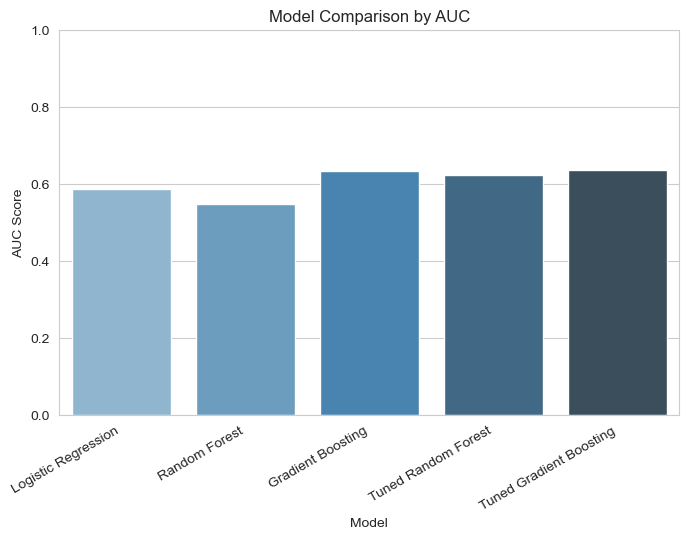

In [35]:
# --- Barplot for AUC ---
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="AUC", data=results, palette="Blues_d")
plt.xticks(rotation=30, ha="right")
plt.title("Model Comparison by AUC")
plt.ylabel("AUC Score")
plt.ylim(0,1)
plt.show()

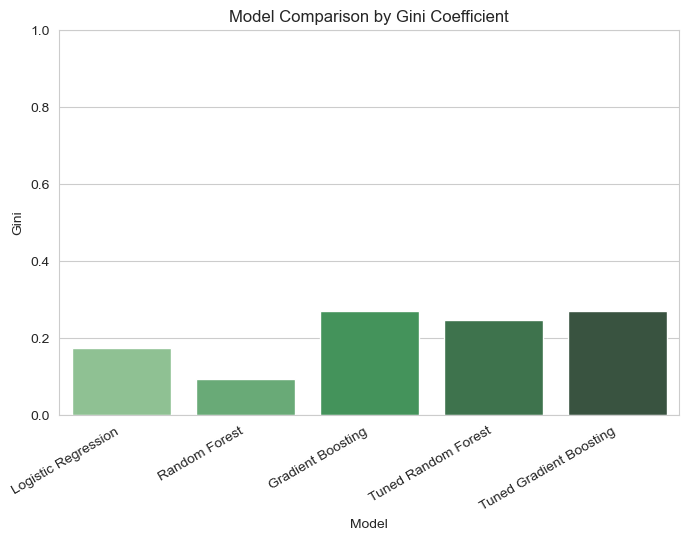

In [36]:
# --- Barplot for Gini ---
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Gini", data=results, palette="Greens_d")
plt.xticks(rotation=30, ha="right")
plt.title("Model Comparison by Gini Coefficient")
plt.ylabel("Gini")
plt.ylim(0,1)
plt.show()


Best Model

* Model were compared using AUC and Gini metrics.
* Tuned Gradient Boosting achieved the highest AUC(0.635329) and Gini(0.270658).
* Hence, Tuned Gradient Boosting is the best model.